# Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

import src.data.scrape as scraper
import src.utils.preprocessing as pre
import src.utils.plotting as plot
import src.models.sentiment_analysis as sa
import src.models.topics_extraction as te
import src.models.predictions as pred
import src.models.cooperation as coop


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/ana

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/ada/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/opt/ana

# Data and Pre-Processing
### Part 1: EDA 

In [2]:
# data = pre.import_RFA()
# print(data.shape)
# data.head(5)

In [3]:
# df_processed, data_eda, unique_elections, unique_candidate_freq_table, single_runners_list, multiple_runners_list, flagged_elec_id = pre.preprossess_eda(data)
# df1 = data_eda.copy()
# votes, df1 = pre.get_votes(df1)

### Part 2: Scraping
We already clean the data and preprocess it so we can do some analysis (parsing the vote, replaceing some characters, etc).

In [4]:
# data_scrap = pre.import_RFA()

# test = scraper.scrape_by_name_all_qs_all_attempts(['RadioKirk', 'Rami R'],data_scarp)
# for name, attempts in test.items():
#     for attempt, questions in attempts.items():
#         print("NAME: ", name)
#         print(attempt)
#         for question, answer in questions.items():
#             print(f"{question} \n{answer}")

In [5]:
# full_q_and_a = scraper.scrape_by_name_all_qs_all_attempts(data_scrap['TGT'].unique(),data_scrap)

# for name, attempts in full_q_and_a.items():
#     for attempt, questions in attempts.items():
#         print("NAME: ", name)
#         print(attempt)
#         for question, answer in questions.items():
#             print(f"{question} \n{answer}")

### Part 3: Running the Sentiment Analysis and Topics Extraction
#### Sentiment Analysis HuggingFace

In [6]:
# sa.sa_hug(data)

#### Sentiment Analysis Vader

In [7]:
# sa.sa_vader()

#### Topics
We are using keyBERT to extract the main topic in questions and answers. Right now, it is still using dummy questions and answers we manually get since we just want to test the overall topic extraction. Soon, we will automate it with the scraped data and see where each topic can influence the decision of the voting

In [8]:
# a,b = te.example_input()
# te.extract_topic(a,b)

We extract the topics from the question and answers pairs.

In [9]:
# te.extract_topic_from_df()

Now we also do the same thing for all the TXT in the main dataset

In [10]:
# te.extract_topic_from_df_text()

In [11]:
# rfa_df, qa_df = pre.complete_prepro_w_sa_topics()

### Part 4: Models
Theses models are commentated as they take a long time to run

In [12]:
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df)
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, smote=True)
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, model_type='small_nn')
# model, rmse, mae, r2 = pred.preprocess_and_predict(rfa_df, model_type='xgboost')
# model, accuracy, report = pred.preprocess_and_predict(rfa_df, model_type='logistic')

- Regression Metrics:
    RMSE: 0.8768
    MAE: 0.7725
    R² Score: 0.1853
- Regression Metrics:
    RMSE: 0.9004
    MAE: 0.8074
    R² Score: 0.1407
- Regression Metrics:
    RMSE: 0.7958
    MAE: 0.6304
    R² Score: 0.3288
- Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
    Regression Metrics:
    RMSE: 0.8243
    MAE: 0.7038
    R² Score: 0.2799
- Classification Metrics:

    Accuracy: 0.4954

                precision    recall  f1-score   support

            -1       0.00      0.00      0.00     12035
            0       0.00      0.00      0.00         0
            1       0.76      0.80      0.78     19537

        accuracy                           0.50     31572
    macro avg       0.25      0.27      0.26     31572
    weighted avg       0.47      0.50      0.48     31572

# Graphs
### Part 1: EDA

In [13]:
# plot.comment_size(data_scrap)

The comment size shows a bit on the activity of users in the discussion forum. It can easily be seen that most users have minimal to no comment in the discussion panel with some having a lot

In [14]:
# plot.plot_byYear(data_scrap)

Plots the number of votes per year between the years 2003 and 2013
We can see how the number of votes vary between the years, it peaked in 2006 then it keeps going down

In [15]:
# plot.boxplot_votes(data_scrap)

We plots the number of votes per user in a box plot format, the 1601 votes outlier is the aggregate of the people whose username was not recorded during their vote. As we can see, there are some groups who votes quite a lot but most people have low participation rate

In [16]:
# plot.boxplot_votes(data_scarp,src='TGT')

Plots the number of votes each candidate has received in a box plot. We can see similar patterns as vote per user as most data values are concentrated around the lower end, while some extreme values (outliers) stretch far above.

### Part 2: SA & Topics

In [17]:
dfsa, qs = pre.complete_prepro_w_sa_topics()

In [18]:
# data = pre.merge_sa_eda(data_eda,dfsa)
data = pd.read_csv('res/data/merged_id_sa.csv')
data = data.drop(columns=['Unnamed: 0'])
data.head(1)

,SRC,TGT,VOT,RES,YEA,DAT,MON,TIM,TXT,elec_id,sentiment,vader_neg,vader_neu,vader_pos,vader_compound,topic_x,topic_y
0,Steel1943,BDD,1,1,2013,2013-04-19,April,23:13:00,Support as conom.,301,POSITIVE,0.0,0.426,0.574,0.4019,support conom,{'best contributions wikipedia'}


In [19]:
# test=pred.linear_pred_influ_vot(dfsa, save=True)

In [20]:
plot.plot_sentiment_byPass(data,prt=True, savefig=True)

In [21]:
plot.plot_sentiment_byPass(data,vader=True,prt=True,savefig=True)

In [22]:
plot.plot_sentiments_byYear(data,prt=True,savefig=True)

In [23]:
plot.plot_sentiments_byYear(data,vader=True,prt=True,savefig=True)

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning:


Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md




,sentiment,topic_x,topic_y,cluster
0,POSITIVE,support conom,{best contributions wikipedia},0
1,POSITIVE,support nominator,{best contributions wikipedia},0
2,POSITIVE,support noms,{best contributions wikipedia},0
3,POSITIVE,support noms bdd,{best contributions wikipedia},0
4,POSITIVE,admin corps,{best contributions wikipedia},0
...,...,...,...,...
198067,POSITIVE,NaN,{wikipedia particularly pleased},0
198068,POSITIVE,editing work,{wikipedia particularly pleased},0
198069,POSITIVE,candidacy number valuable,{wikipedia particularly pleased},0
198070,NEGATIVE,edits necessary,{wikipedia particularly pleased},0


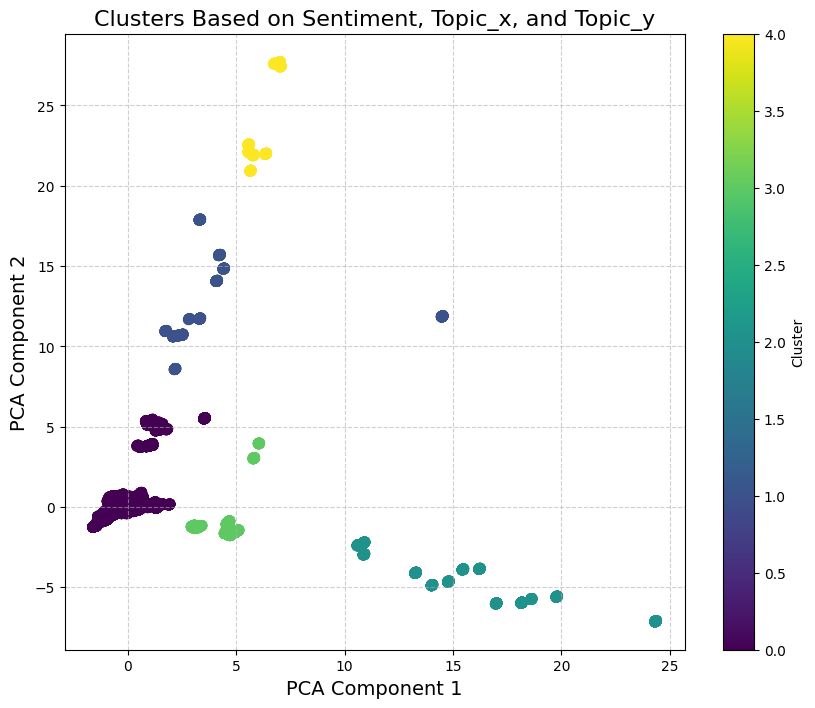

In [24]:
plot.plot_clusters()

In [25]:
# plot.visualize_cooperation()

In [26]:
plot.plot_topics_pass(data,prt=True,savefig=True)

In [27]:
plot.plot_topics_pass(data, comment=False,prt=True,savefig=True)